In [1]:
import datetime
import pandas as pd
import numpy as np
import scipy.stats as sm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
def pythonisShit(val, lag = 0):
    a, b = val.split('+')
    return datetime.datetime.strptime(a+b[5:], '%a %b %d %H:%M:%S %Y') - datetime.timedelta(hours = lag)

In [3]:
def parseDF(df, day, start, weeklySecs):
    df['Created_at'] = df.apply(lambda x : pythonisShit(x['created_at'], lag = 5), axis = 1)
    df.sort_values('Created_at', inplace=True, ascending=True)
    df.reset_index(drop=True, inplace=True)
    df['Sec_Elapsed'] = df.apply(lambda x : (x['Created_at'] - start).total_seconds(), axis = 1)
    df = df[df['Sec_Elapsed'] >= 0]
    pd.options.mode.chained_assignment = None  # default='warn'
    df['Week'], df['Sec_in_week'] = np.divmod(df['Sec_Elapsed'], weeklySecs)
    return df[['Created_at', 'Sec_Elapsed', 'Week', 'Sec_in_week']]

In [4]:
def main(df, day, adjustment = 0, tweets = None, timedelta = 0, brackets = None, ignores = []):
    if day == 'Tuesday':
        start = datetime.datetime.strptime('11/07/2017 12:00', "%m/%d/%Y %H:%M")
    elif day == 'Wednesday':
        start = datetime.datetime.strptime('11/08/2017 12:00', "%m/%d/%Y %H:%M")
    elif day == "Friday":
        start = datetime.datetime.strptime('11/10/2017 12:00', "%m/%d/%Y %H:%M")
    else:
        raise ValueError('StartDate not Properly Specified')
    weeklySecs = 60*60*24*7
    df = parseDF(df, day, start, weeklySecs)
    curr = int((datetime.datetime.now() - start + datetime.timedelta(hours = timedelta)).total_seconds())
    week, now = divmod(curr, weeklySecs)
    
    ignores_ = [] 
    if len(ignores):
        for i in ignores:
            ignores_.append(divmod((i - start).total_seconds(), weeklySecs)[0])
    
    pastData = []
    
    currTimes = [0]+ [int(t) for t in df[df['Week'] == week]['Sec_in_week'].values] + [now]
    currCounts = list(np.array(range(len(currTimes)))+adjustment)
    if tweets:
        currCounts[-1] = tweets
    else:
        currCounts[-1] -= 1
        tweets = currCounts[-1]
    pastData.append(zip(currTimes, currCounts))
    
    for i in xrange(week):
        if i not in ignores_:
            times = [0]+ [int(t) for t in df[df['Week'] == i]['Sec_in_week'].values] + [weeklySecs]
            counts = range(len(times))
            counts[-1] -= 1
            pastData.append(zip(times, counts))
    
    sns.set_palette(sns.cubehelix_palette(len(pastData), rot = 3))
        
    step = 60*60*12
    timeLeft = weeklySecs-now
    
    times = np.linspace(now, weeklySecs, 2 + timeLeft/step)[1:]
    
    max_ = times[-1]

    bounds = [.025, .25, .5, .75, .975]
    m = len(bounds)
    toPlot1 = [(now, tweets)]*m
    #toPlot2 = [(now, tweets)]*m
    for t in times:
        dataToLearn = list(df[(df['Sec_in_week'] <= t) & (df['Sec_in_week'] > now) & (~df['Week'].isin(ignores_))]['Week'].value_counts().values)
        expected_Len = week - len(ignores)
        while len(dataToLearn) < expected_Len:
            dataToLearn.append(0)
        shape,  loc,  scale = sm.lognorm.fit(dataToLearn, floc = 0)
        shape2, loc2, scale2 = sm.gamma.fit(dataToLearn)
        for b in bounds:
            toPlot1.append((t, tweets+sm.lognorm.ppf(b, s = shape, loc = loc, scale = scale)))
            #toPlot2.append((t, tweets+sm.gamma.ppf(b, a = shape2, loc = loc2, scale = scale2)))
        if t == max_ and brackets:
            probs1 = [sm.lognorm.cdf(bra-tweets, s = shape, loc = loc, scale = scale) for bra in brackets]
            #probs2 = [sm.gamma.cdf(bra-tweets, a = shape2, loc = loc2, scale = scale2) for bra in brackets]

    if brackets:
        for i, p in enumerate(probs1):
            if i:
                print "{}-{} Bracket: {}".format(brackets[i-1], brackets[i]-1, round((probs1[i] - probs1[i-1])*100,2))
        #for i, p in enumerate(probs2):
        #    if i:
        #        print "{}-{} Bracket: {}".format(brackets[i-1], brackets[i]-1, round((probs2[i] - probs2[i-1])*100,2))
            
    plt.figure(figsize=(20,15))

    for i, p in enumerate(pastData):
        a, b = zip(*p)
        x = plt.plot(a, b)
        if not i:
            col = x[0].get_color()

    for i in xrange(m):
        plt.plot(*zip(*toPlot1[i::m]), linestyle = 'dashed', color = '#17becf')
        #plt.plot(*zip(*toPlot2[i::m]), linestyle = 'dashed', color = 'red')
        
    print start+datetime.timedelta(seconds = curr), 'with', tweets, 'tweets'
    for p, v in zip(bounds, zip(*toPlot1[-m:])[1]):
        print p,
        for _ in xrange(6-len(str(p))):
            print '',
        print round(v, 2)
    
    plt.xlim(-2000, weeklySecs+2000)

0-34 Bracket: 3.11
35-39 Bracket: 18.27
40-44 Bracket: 29.66
45-49 Bracket: 24.44
50-54 Bracket: 13.9
55-59 Bracket: 6.41
60-inf Bracket: 4.19
2018-02-13 21:27:59 with 21 tweets
0.025  34.62
0.25   40.65
0.5    44.82
0.75   49.87
0.975  62.65


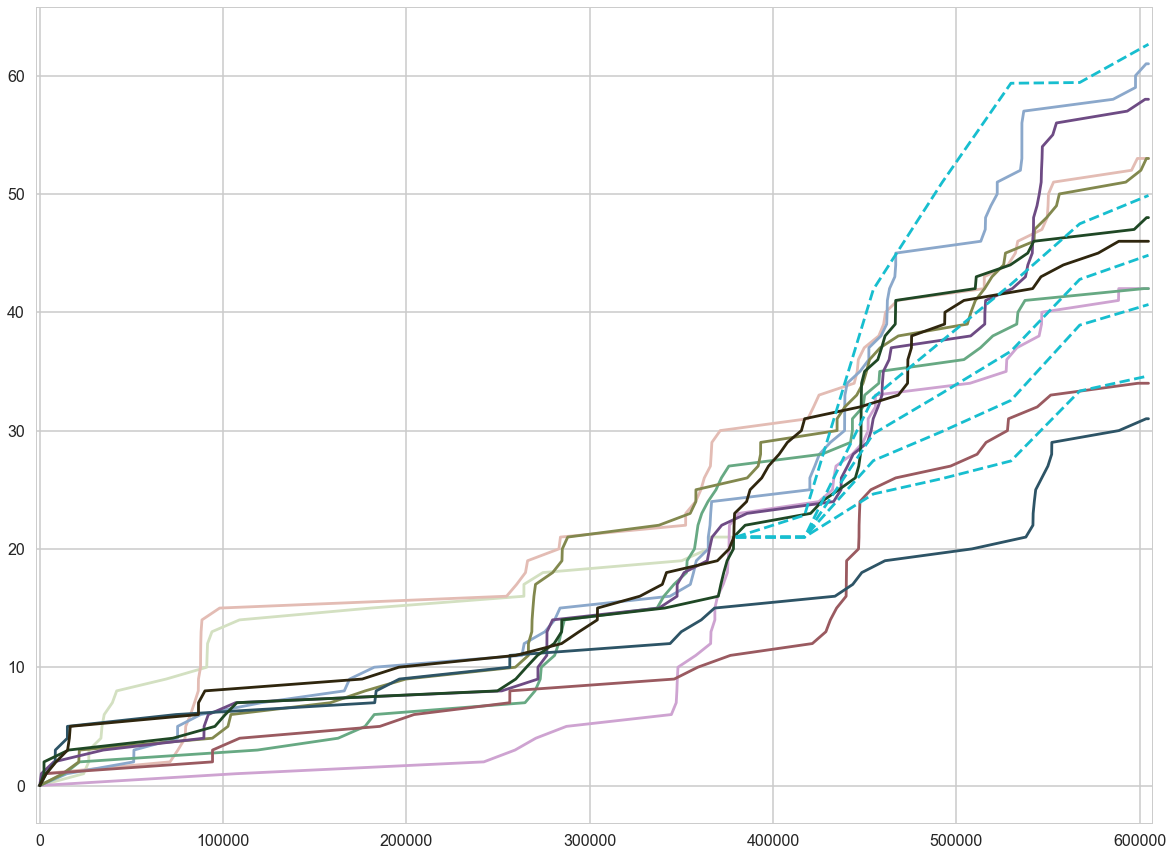

In [6]:
pence = pd.read_csv('vp.csv')
main(pence, 'Friday', tweets = 21, brackets = [0,35,40,45,50,55,60,np.inf], ignores = 
    [datetime.datetime.strptime('12/25/2017 11:00', "%m/%d/%Y %H:%M"), 
    datetime.datetime.strptime('11/23/2017 11:00', "%m/%d/%Y %H:%M"),
    datetime.datetime.strptime('1/23/2018 11:00', "%m/%d/%Y %H:%M")])

0-29 Bracket: 0.0
30-34 Bracket: 70.67
35-39 Bracket: 23.81
40-44 Bracket: 4.17
45-49 Bracket: 0.94
50-54 Bracket: 0.26
55-inf Bracket: 0.14
2018-02-13 21:28:00 with 30 tweets
0.025  30.96
0.25   32.24
0.5    33.5
0.75   35.45
0.975  42.7


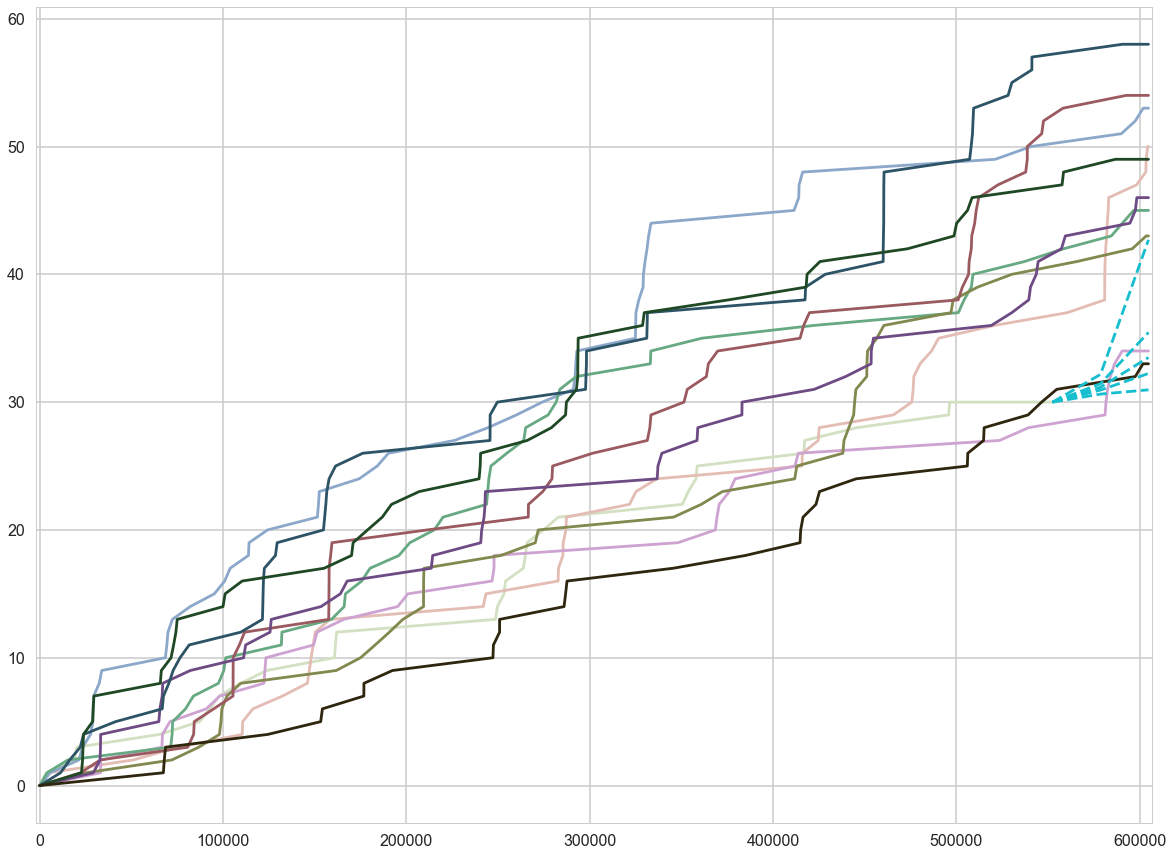

In [7]:
rdt = pd.read_csv('realdonaldtrump.csv')
main(rdt, 'Wednesday', tweets = 30, brackets = [0,30,35,40,45,50,55,np.inf], ignores = 
    [datetime.datetime.strptime('12/25/2017 11:00', "%m/%d/%Y %H:%M"), 
    datetime.datetime.strptime('11/23/2017 11:00', "%m/%d/%Y %H:%M"),
    datetime.datetime.strptime('1/30/2018 11:00', "%m/%d/%Y %H:%M")])

0-39 Bracket: 98.06
40-44 Bracket: 1.1
45-49 Bracket: 0.47
50-54 Bracket: 0.21
55-59 Bracket: 0.09
60-64 Bracket: 0.04
65-inf Bracket: 0.04
2018-02-13 21:28:01 with 3 tweets
0.025  10.61
0.25   15.61
0.5    19.43
0.75   24.42
0.975  38.49


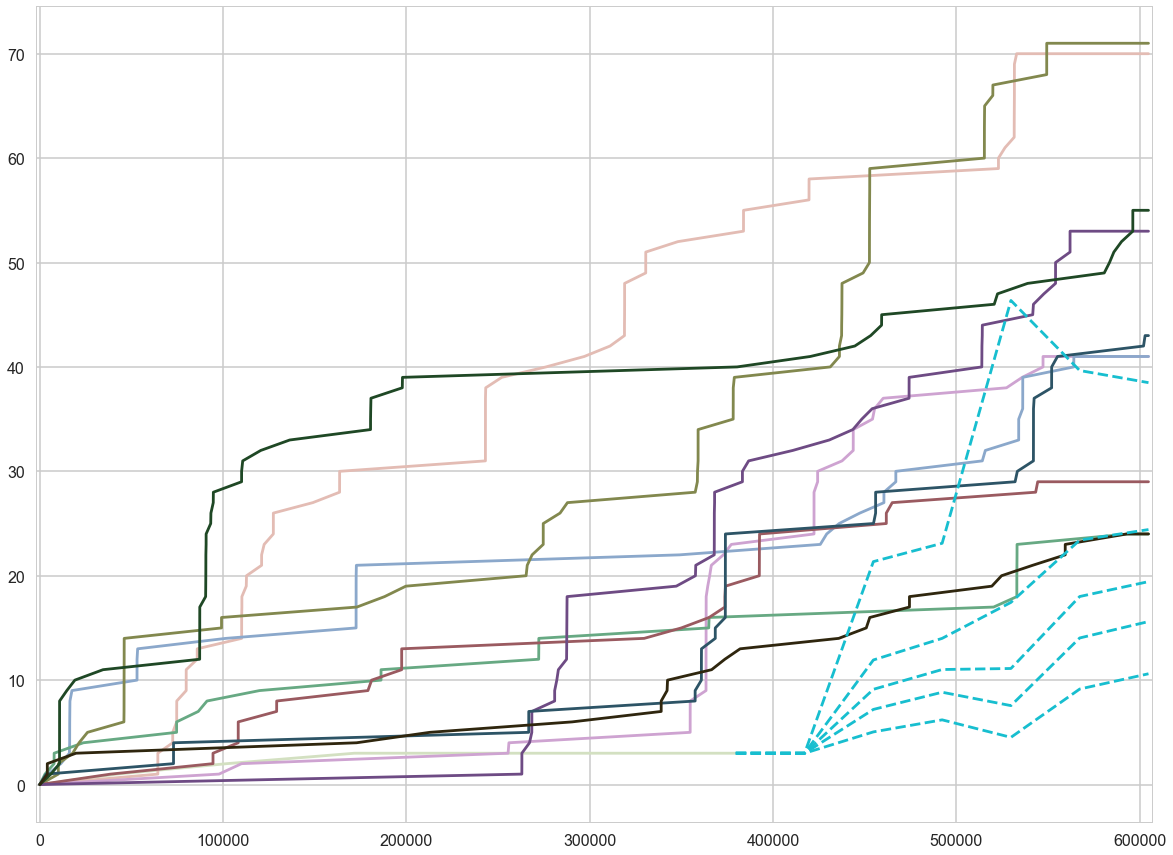

In [8]:
potus = pd.read_csv('potus.csv')
main(potus, 'Friday', tweets = 3, brackets = [0,40,45,50,55,60,65,np.inf], ignores = 
    [datetime.datetime.strptime('12/25/2017 11:00', "%m/%d/%Y %H:%M"), 
    datetime.datetime.strptime('11/23/2017 11:00', "%m/%d/%Y %H:%M"),
    datetime.datetime.strptime('02/01/2018 11:00', "%m/%d/%Y %H:%M")])